In [1]:
import sys
import os
from torchvision import transforms
import numpy as np

from PIL import Image
from transformers import TableTransformerForObjectDetection, AutoModelForObjectDetection
import easyocr

# Give priority to the modules that are inside tableTransformer 
# and handles the conflict between tableTransformer/detr/datasets and hugging face datasets' library
sys.path.insert(1, os.getcwd() + '/tableTransformer/src')
sys.path.insert(2, os.getcwd() + '/tableTransformer/detr')
# This snipet is necessary for inference to work

from tableTransformer.src.inference import TableExtractionPipeline, MaxResize, rescale_bboxes, objects_to_structures, structure_to_cells, cells_to_html, cells_to_csv, objects_to_crops # , outputs_to_objects

from tableTransformer.src.inference import output_result


/home/martin/miniconda3/envs/tables-detr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def outputs_to_objects(outputs, img_size, class_idx2name):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = class_idx2name[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

class PretrainTableExtractionPipeline(TableExtractionPipeline): 
    def __init__(
        self, 
        det_device=None, str_device=None,
        det_model=None, str_model=None
    ):
        super().__init__(
            det_device=det_device, str_device=str_device
        )
        if det_model is not None: 
            self.det_model = det_model
            self.det_model.to(det_device)
        if str_model is not None: 
            self.str_model = str_model
            self.str_model.to(str_device)


    def detect(
        self, 
        img, tokens=[], 
        out_objects=True, 
        out_crops=False, 
        crop_padding=10
    ):
        out_formats = {}
        if self.det_model is None:
            print("No detection model loaded.")
            return out_formats

        # Transform the image how the model expects it
        img_tensor = detection_transform(img)

        # Run input image through the model
        outputs = self.det_model(img_tensor.unsqueeze(0).to(self.det_device))

        # Post-process detected objects, assign class labels
        objects = outputs_to_objects(outputs, img.size, self.det_class_idx2name)
        if out_objects:
            out_formats['objects'] = objects
        if not out_crops:
            return out_formats

        # Crop image and tokens for detected table
        if out_crops:
            tables_crops = objects_to_crops(img, tokens, objects, self.det_class_thresholds,
                                            padding=crop_padding)
    
            out_formats['crops'] = tables_crops
        
        return out_formats

    def recognize(
        self, 
        img, tokens=[], 
        out_objects=False, 
        out_cells=False,
        out_html=False, 
        out_csv=False
    ):
        out_formats = {}
        if self.str_model is None:
            print("No structure model loaded.")
            return out_formats

        if not (out_objects or out_cells or out_html or out_csv):
            print("No output format specified")
            return out_formats

        # Transform the image how the model expects it
        img_tensor = structure_transform(img)

        # Run input image through the model
        outputs = self.str_model(img_tensor.unsqueeze(0).to(self.str_device))

        # Post-process detected objects, assign class labels
        objects = outputs_to_objects(outputs, img.size, self.str_class_idx2name)
        if out_objects:
            out_formats['objects'] = objects
        if not (out_cells or out_html or out_csv):
            return out_formats

        # Further process the detected objects so they correspond to a consistent table 
        tables_structure = objects_to_structures(objects, tokens, self.str_class_thresholds)

        # Enumerate all table cells: grid cells and spanning cells
        tables_cells = [structure_to_cells(structure, tokens)[0] for structure in tables_structure]
        if out_cells:
            out_formats['cells'] = tables_cells
        if not (out_html or out_csv):
            return out_formats

        # Convert cells to HTML
        if out_html:
            tables_htmls = [cells_to_html(cells) for cells in tables_cells]
            out_formats['html'] = tables_htmls

        # Convert cells to CSV, including flattening multi-row column headers to a single row 
        if out_csv:
            tables_csvs = [cells_to_csv(cells) for cells in tables_cells]
            out_formats['csv'] = tables_csvs

        return out_formats



In [3]:
TABLE_DETECTION_MODEL = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm") # AutoModelForObjectDetection
TABLE_STRUCTURE_MODEL = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition-v1.1-all") # -all -fin -pub

TABLE_DETECTION_DEVICE = "cpu"
TABLE_STRUCTURE_DEVICE = "cpu"

In [4]:
table_extraction_pipeline = PretrainTableExtractionPipeline(
    det_device=TABLE_DETECTION_DEVICE, 
    str_device=TABLE_STRUCTURE_DEVICE, 
    det_model=TABLE_DETECTION_MODEL,
    str_model=TABLE_STRUCTURE_MODEL
)

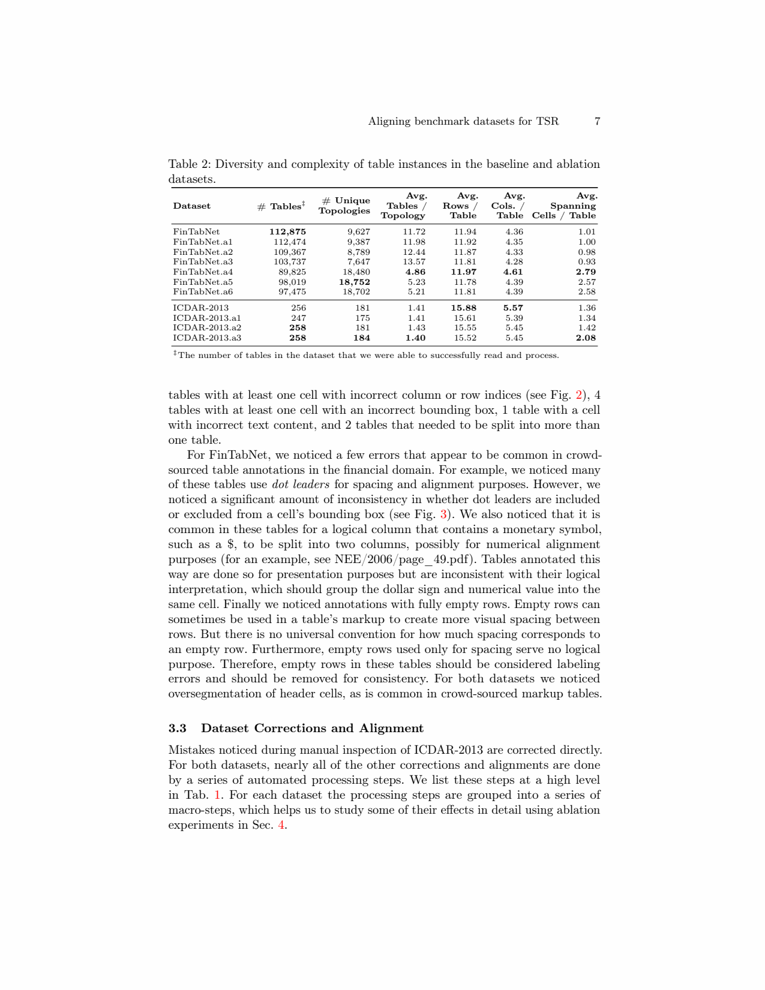

In [5]:
img_file = f'2303_00716.jpg'

image = Image.open(img_file).convert("RGB")
width, height = image.size

display(image.resize((int(0.6*width), (int(0.6*height)))))

In `docs/inference.md` it is said that `tokens` is expected to be a list of dictionaries and contains a list of words and their bounding boxes in image coordinates. It is assumed to be sorted in reading order. The format for tokens is:  
```
[
    {
        'bbox': [0.0, 0.0, 50.0, 50.0],
        'text': 'First'
        'span_num': 1,
        'line_num': <<line_num>> || 0,
        'block_num': <<block_num>> || 0
    },
    {
        'bbox': [52.0, 0.0, 102.0, 50.0],
        'text': 'next'
        'span_num': 2,
        'line_num': <<line_num>> || 0,
        'block_num': <<block_num>> || 0
    }
]
```

Get Tokens with easyocr: 
- https://medium.com/@adityamahajan.work/easyocr-a-comprehensive-guide-5ff1cb850168
- https://github.com/microsoft/table-transformer/discussions/146 - improve noisy image quality
- https://github.com/microsoft/table-transformer/issues/121 - generate tokens for image and pdf

Multiple approaches can be tested:
- ocr the whole doc and pass the tokens to the pipline (this should work because the `extract` method re assign `tokens` with output of previous step in the pipline) 
- ocr the cropped tables and pass the tokens to the recognize function
- ocr every cell like in this tutorial: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Inference_with_Table_Transformer_(TATR)_for_parsing_tables.ipynb

## OCR the whole document

In [6]:
READER_LANGUAGE = 'en'
reader = easyocr.Reader(lang_list=[READER_LANGUAGE])
results = reader.readtext(img_file)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


### Build the tokens sequence

In [7]:
tokens = [
    {
        'bbox': [
            float(coord) for coord in [ 
                bbox_coord[0][0], bbox_coord[0][1], bbox_coord[2][0], bbox_coord[2][1] 
            ]
        ],
        'text': text,
        'proba': proba,
        'span_num': i,
        'line_num': 0,
        'block_num': 0
    }
    for i, (bbox_coord, text, proba) in enumerate(results)
] 

### One step table extraction 

In [8]:
args = type('Args', (object,), {
    'visualize': True, 
    'out_dir': 'outputs/one_step_extraction/',
    'verbose': False
} )

out_options = {
    'out_objects': True,
    'out_cells': True,
    'out_html': True,
    'out_csv': True
}

extracted_tables = table_extraction_pipeline.extract(image, tokens=tokens, **out_options)

In [9]:
for table_idx, extracted_table in enumerate(extracted_tables):
    for key, val in extracted_table.items():
        output_result(key, val, args, extracted_table['image'], img_file.replace('.jpg', f'_{table_idx}.jpg'))

Its is okay, the is a `,` that become `.,` and another that become `.` and there is a `4` that disapear 

## OCR the only the cropped tables

### Two Steps table extraction

In [10]:
detection_out_options = {
    'out_objects': True,
    'out_crops': True
}
structure_out_options = {
    'out_objects': True,
    'out_cells': True,
    'out_html': True,
    'out_csv': True
}

args = type('Args', (object,), {
    'visualize':True,
    'out_dir': 'outputs/two_steps_extraction/',
    'verbose': False
})

detected_tables = table_extraction_pipeline.detect(image, **detection_out_options)

for crop_idx, crop_table in enumerate(detected_tables['crops']): 
    crop_image = crop_table['image']
    crop_image_text = reader.readtext(np.array(crop_image))
    crop_tokens = [
        {
            'bbox': [ 
                float(coord) for coord in [ 
                    bbox_coord[0][0], bbox_coord[0][1], bbox_coord[2][0], bbox_coord[2][1] 
                ]
            ],
            'text': text,
            'proba': proba,
            'span_num': i,
            'line_num': 0,
            'block_num': 0
        }
        for i, (bbox_coord, text, proba) in enumerate(crop_image_text)
    ] 
    
    table_structure = table_extraction_pipeline.recognize(
        crop_image, 
        crop_tokens, 
        **out_options
    )

    for key, val in table_structure.items():
        output_result(key, val, args, crop_image, f'crop_{crop_idx}_{img_file}')